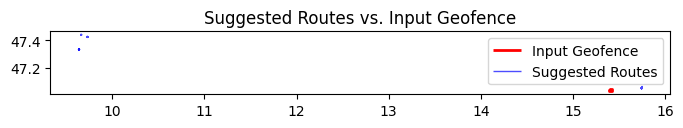

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
import json

# Load the historical tracking data with waypoints
waypoints_df = pd.read_parquet("../Data_Preperation/gps_data_relaxed_parameters_more.parquet")  # Adjust filename

# Example input geofence (replace with real input)
geofence_coords = [
    [15.39115201797813, 47.04613526180805],
    [15.39115201797813, 47.02472022658941],
    [15.425096301947633, 47.02472022658941],
    [15.425096301947633, 47.04613526180805]
]
geofence_poly = Polygon(geofence_coords)

# Suggested routes from the API response (replace with actual API response)
suggested_routes = [
    {"id_tracking": 68223},
    {"id_tracking": 81628},
    {"id_tracking": 73818},
    {"id_tracking": 73121},
    {"id_tracking": 88119}
]

# Convert geofence to GeoDataFrame
gdf_geofence = gpd.GeoDataFrame(geometry=[geofence_poly], crs="EPSG:4326")

# Extract waypoints for the suggested routes
route_geometries = []
for route in suggested_routes:
    tracking_id = route["id_tracking"]
    route_waypoints = waypoints_df[waypoints_df["id_tracking"] == tracking_id]
    
    if not route_waypoints.empty:
        route_geometry = LineString(zip(route_waypoints["longitude"], route_waypoints["latitude"]))
        route_geometries.append(route_geometry)

# Convert routes to GeoDataFrame
gdf_routes = gpd.GeoDataFrame(geometry=route_geometries, crs="EPSG:4326")

# Plot everything
fig, ax = plt.subplots(figsize=(8, 8))
gdf_geofence.boundary.plot(ax=ax, color="red", linewidth=2, label="Input Geofence")
gdf_routes.plot(ax=ax, color="blue", linewidth=1, alpha=0.7, label="Suggested Routes")

plt.legend()
plt.title("Suggested Routes vs. Input Geofence")
plt.show()


In [8]:
import numpy as np
import osmnx as ox
from fastapi import FastAPI, HTTPException

def extract_osm_features(geofence_poly):
    """
    Extracts OSM-style road network features from the given geofence.
    """
    try:
        # Convert geofence to bounding box
        min_lon, min_lat, max_lon, max_lat = geofence_poly.bounds

        # Get the road network from OSM
        G = ox.graph_from_bbox((min_lon, min_lat, max_lon, max_lat), network_type="drive")

        # Compute the area of the geofence in km² using geopandas
        import geopandas as gpd
        gdf = gpd.GeoDataFrame(geometry=[geofence_poly], crs="EPSG:4326").to_crs(epsg=3857)
        area_km2 = gdf.geometry.area.iloc[0] / 1e6

        # Compute OSM-based road statistics
        stats = ox.basic_stats(G, area=area_km2)

        # Extract and align with tracking data
        osm_features = {
            "total_distance": stats.get("edge_length_total", 0) / 1000,  # Convert meters to km
            "node_density": stats.get("node_density_km", 0),
            "street_density": stats.get("street_density_km", 0),
            "avg_street_segment_length": stats.get("street_length_avg", 0),
            "intersection_density": stats.get("intersection_density_km", 0),
            "circuity_avg": stats.get("circuity_avg", 0),
            "self_loop_proportion": stats.get("self_loop_proportion", 0),
            "street_segment_count": stats.get("street_segment_count", 0),
            "streets_per_node_avg": stats.get("streets_per_node_avg", 0)
        }

        # Convert to numpy array for nearest neighbor matching
        return np.array([osm_features[key] for key in osm_features.keys()]).reshape(1, -1)

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"OSM feature extraction error: {e}")


In [9]:
# Example: Assume you already have a geofence polygon input
geofence_poly = Polygon(geofence_coords)

# Extract OSM features for the input area
osm_feature_vector = extract_osm_features(geofence_poly)

# Convert it into a DataFrame for comparison
osm_features_df = pd.DataFrame(osm_feature_vector, columns=[
    "total_distance", "node_density", "street_density",
    "avg_street_segment_length", "intersection_density",
    "circuity_avg", "self_loop_proportion", "street_segment_count", "streets_per_node_avg"
])

# Get suggested routes' features
suggested_routes_df = track_features[track_features["id_tracking"].isin([route["id_tracking"] for route in suggested_routes])]

# Compare feature distributions
print("OSM Features for Input Geofence:")
print(osm_features_df)

print("\nSuggested Routes Features:")
print(suggested_routes_df)

# Compute absolute differences
feature_differences = (suggested_routes_df.drop(columns=["id_tracking"]) - osm_features_df.iloc[0]).abs()
print("\nFeature Differences:")
print(feature_differences.mean())  # Show mean absolute differences


NameError: name 'track_features' is not defined